# Investigate default simulations for wilting point, field capacity and saturated soil moisture content

Inne Vanderkelen - October 2023

## 1. Settings

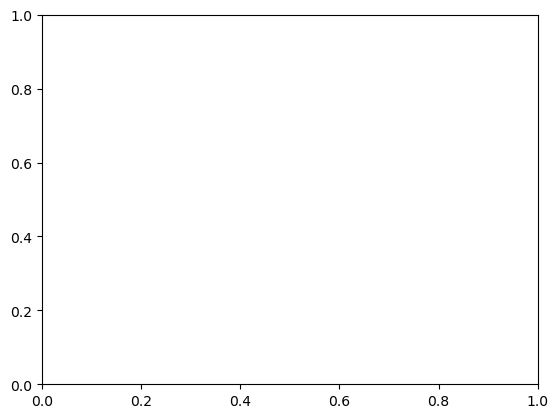

In [1]:
# laod modules 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github .com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'
outdir = '/project/s1207/ivanderk/scratch/'

figdir = '/users/ivanderk/notebooks_4p1000/figures/'

outdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/'
figdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/4p1000/figures/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = 'high'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.CTL.spunup' # this case is running. 
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.'+scenario+'.spunup'
# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'


case   = case_ctl
block  = 'lnd' 
stream = 'h0' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ["H2OSOI", "watsat", "watfc"]

# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 # 2028 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

proj =  ccrs.Robinson()

## 2. Load data

### Load simulations

In [4]:
ds_ctl = import_case(case_ctl, myVars=variables, timeSlice=time_slice)

In [5]:
ds_scen = import_case(case_scen, myVars=variables, timeSlice=time_slice)

In [6]:
ds_delta = ds_scen - ds_ctl 

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [7]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [10]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']
case_ctl_forinputdata = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl_forinputdata)

In [11]:
# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

### Plotting settings

In [12]:
## settings

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

plotting_depth = 2 # m 8
figsize = (17,38)
labels = ['a.','b.','c.','d.','e.','f.','g.']

## 3. Analysis & plotting

In [13]:
# calculate difference in water holding capacity. 

# delta field capacity
da_fc_ctl =  ds_ctl['watfc'][:,0:10,:,:].rename({'levgrnd':'levsoi'})
da_fc_scen =  ds_scen['watfc'][:,0:10,:,:].rename({'levgrnd':'levsoi'})

da_fc_ctl['levsoi'] = da_wilting_h2osoi_scen['levsoi']
da_fc_scen['levsoi'] = da_wilting_h2osoi_scen['levsoi']

da_whc_ctl =  (da_fc_ctl - da_wilting_h2osoi)
da_whc_scen = (da_fc_scen  - da_wilting_h2osoi_scen)

# delta wilting point
da_delta_whc =  da_whc_scen - da_whc_ctl
da_delta_whc_rel = (da_delta_whc/abs(da_whc_ctl)*100).weighted(da_delta_whc['levsoi']).mean(dim='levsoi').mean('time').compute()


In [14]:
# calculate saturated fraction
da_h2o_ctl  =  ds_ctl['H2OSOI'][:,0:10,:,:]
da_h2o_scen =  ds_scen['H2OSOI'][:,0:10,:,:]

da_delta_h2o = da_h2o_scen - da_h2o_ctl
da_delta_h2o_rel =  ((da_delta_h2o / abs(da_h2o_ctl)).weighted(da_delta_h2o['levsoi']).mean(dim='levsoi').mean('time')*100).compute()

# water content at saturation
da_sat_ctl =  ds_ctl['watsat'][:,0:10,:,:].rename({'levgrnd':'levsoi'})
da_sat_scen =  ds_scen['watsat'][:,0:10,:,:].rename({'levgrnd':'levsoi'})

da_satfrac_ctl = da_h2o_ctl/da_sat_ctl
da_satfrac_scen = da_h2o_scen/da_sat_scen

da_delta_satfrac =  (da_satfrac_scen - da_satfrac_ctl)
da_delta_satfrac_rel =  ((da_delta_satfrac / abs(da_satfrac_ctl)).weighted(da_delta_satfrac['levsoi']).mean(dim='levsoi').mean('time')*100).compute()

In [15]:
da_delta_sat = da_sat_scen - da_sat_ctl 
da_delta_sat_rel =  ((da_delta_sat / abs(da_sat_ctl)).weighted(da_delta_sat['levsoi']).mean(dim='levsoi').mean('time')*100).compute()

In [16]:
da_whcsat_ctl =  (da_sat_ctl - da_wilting_h2osoi)
da_sat_scen['lat'] = da_wilting_h2osoi_scen.lat
da_wilting_h2osoi_scen['levsoi'] = da_sat_ctl.levsoi

da_whcsat_scen = (da_sat_scen.compute() - da_wilting_h2osoi_scen)

da_delta_whcsat =  da_whcsat_scen - da_whcsat_ctl
da_delta_whcsat = da_delta_whcsat.weighted(da_delta_whcsat['levsoi']).mean(dim='levsoi')
da_whcsat_ctl= da_whcsat_ctl.weighted(da_whcsat_ctl['levsoi']).mean(dim='levsoi')

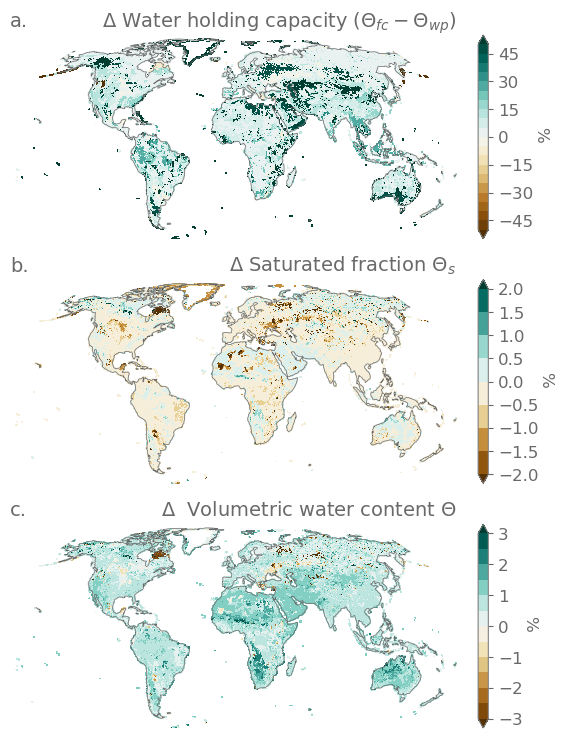

In [22]:
vlims=[-10,10]

#fig, axes = plt.subplots(3,1,figsize=(12,12),subplot_kw={'projection': proj, 'frameon':False})

fig, axes = plt.subplots(3,1, figsize = (7,9) ,subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

# delta water content
ax = axes[0]
label = labels[0]
da_toplot = da_delta_whc_rel
title = '$\Delta$ Water holding capacity ($\Theta_{fc} - \Theta_{wp}$)'
levels = np.arange(-20,22.5,2.5)
levels = np.arange(-50,55,5)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


# delta saturated water content
ax = axes[1]
label = labels[1]
da_toplot = da_delta_satfrac_rel
title = '$\Delta$ Saturated fraction $\Theta_{s}$ '
levels = np.arange(-1,1.1,0.1)
levels = np.arange(-2,2.5,0.5)


da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


ax = axes[2]
label = labels[2]
da_toplot = da_delta_h2o_rel
title = '$\Delta$  Volumetric water content $\Theta$'
levels = np.arange(-1,1.1,0.1)
levels = np.arange(-3,3.5,0.5)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')

ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


fig.tight_layout()
fig.savefig(figdir+'waterholdingcapacity.png')

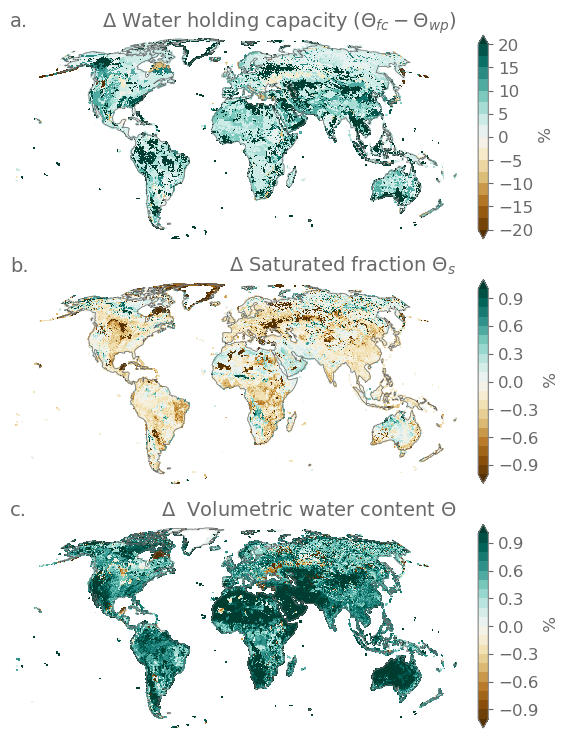

In [18]:
vlims=[-10,10]

#fig, axes = plt.subplots(3,1,figsize=(12,12),subplot_kw={'projection': proj, 'frameon':False})

fig, axes = plt.subplots(3,1, figsize = (7,9) ,subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

# delta water content
ax = axes[0]
label = labels[0]
da_toplot = da_delta_whc_rel
title = '$\Delta$ Water holding capacity ($\Theta_{fc} - \Theta_{wp}$)'
levels = np.arange(-20,22.5,2.5)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


# delta saturated water content
ax = axes[1]
label = labels[1]
da_toplot = da_delta_satfrac_rel
title = '$\Delta$ Saturated fraction $\Theta_{s}$ '
levels = np.arange(-1,1.1,0.1)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


ax = axes[2]
label = labels[2]
da_toplot = da_delta_h2o_rel
title = '$\Delta$  Volumetric water content $\Theta$'
levels = np.arange(-1,1.1,0.1)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')

ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


fig.tight_layout()
fig.savefig(figdir+'waterholdingcapacity.png')